In [1]:
import warnings

warnings.filterwarnings("ignore")

from climada.entity import ImpactFuncSet, ImpfTropCyclone
from climada.engine import ImpactCalc
from climada.util.api_client import Client
from climada.util.constants import CMAP_IMPACT
from climada.util.plot import plot_from_gdf
import numpy as np

client = Client()
haz_tc_haiti = client.get_hazard(
    "tropical_cyclone",
    properties={
        "country_name": "Haiti",
        "climate_scenario": "historical",
        "nb_synth_tracks": "10",
    },
)
haz_tc_haiti.check()

In [2]:
# prepare exposure
from climada.util.api_client import Client
client = Client()


exposure = client.get_litpop(country="Haiti")
exposure.check()

In [3]:
# prepare impact function

impf_tc = ImpfTropCyclone.from_emanuel_usa()
impf_set = ImpactFuncSet([impf_tc])
impf_set.check()

In [4]:
# compute impact

impact = ImpactCalc(exposure, impf_set, haz_tc_haiti).impact(save_mat=True)

In [5]:
np.unique(1/haz_tc_haiti.frequency/11, return_counts=True)

(array([ 8., 31., 41.]), array([   33,  2893, 40634]))

In [6]:
# compute local exceedance instensity
test_return_periods = np.geomspace(.01, 341, 100)
local_exceedance_intensity, label, title = impact.local_exceedance_impact(
    return_periods=test_return_periods#, method="extrapolate_constant"#method="extrapolate" method="extrapolate_constant"
)

In [7]:
from return_period_maps import ReturnPeriodMap, ExceedanceCurve
rp_map = ReturnPeriodMap.from_CLIMADA_local_exceedance_intensity(local_exceedance_intensity)

<Axes: >

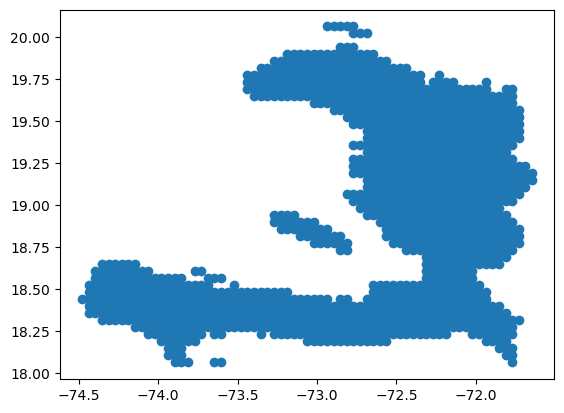

In [8]:
rp_map.geometry.plot()

In [9]:
from coordinates import change_grid_resolution

change_grid_resolution(rp_map.geometry, 2)[0]


0      POINT (-74.45833 18.08333)
1      POINT (-74.45833 18.16667)
2      POINT (-74.45833 18.25000)
3      POINT (-74.45833 18.33333)
4      POINT (-74.45833 18.41667)
                  ...            
811    POINT (-71.70833 19.66667)
812    POINT (-71.70833 19.75000)
813    POINT (-71.70833 19.83333)
814    POINT (-71.70833 19.91667)
815    POINT (-71.70833 20.00000)
Length: 816, dtype: geometry

In [10]:
rp_map.compute_aai_aggregated()

186437646.3633925

In [11]:
rp_map.compute_aai_per_centroid()

array([3558.06885367, 3792.78507005,  990.38436924, ...,  748.91451823,
       1364.45163179, 1337.42499493])

In [12]:
rp_map_half =  rp_map.coarsen(scale_factor=2, coincidence_fraction=1)


In [13]:
for curve in rp_map_half.exceedance_curves:
    print(curve.values)

[nan nan]
[nan nan]
[nan nan]
[4.58407795e+01 1.20913572e+02 1.77595396e+02 7.37365887e+02
 1.38676386e+03 1.52076495e+03 2.02257296e+03 2.48573920e+03
 3.01383926e+03 3.80293277e+03 4.78856920e+03 5.94556323e+03
 6.96897286e+03 9.34805247e+03 1.15631575e+04 2.60456357e+04
 3.06679053e+04 3.51348129e+04 4.25072305e+04 4.55429505e+04
 5.93147414e+04 6.49616498e+04 7.11461576e+04 7.88114224e+04
 8.63995392e+04            nan]
[155336.45362929             nan]
[   936.31843658   1028.54704139  21274.74339581  22756.70831096
  30612.27124609 118822.78223218 150878.22581771 205012.06937749
             nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[25753.14193312            nan]
[50008.57752184            nan]
[nan]
[nan]
[1.08230153e+02 2.30393628e+02 3.31943355e+02 8.79799805e+02
 1.30638439e+03 2.27873792e+03 2.79620024e+